In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Знакомство с данными

In [13]:
data = pd.read_csv('./data/train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73995 entries, 0 to 73994
Data columns (total 72 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   user_id                         73995 non-null  uint64 
 1   org_id                          73995 non-null  uint64 
 2   rating                          73995 non-null  float64
 3   ts                              73995 non-null  int64  
 4   user_city                       73995 non-null  object 
 5   org_city                        73995 non-null  object 
 6   average_bill                    45433 non-null  float64
 7   rating_org                      73995 non-null  float64
 8   rubrics                         73995 non-null  object 
 9   food_delivery                   73995 non-null  int64  
 10  breakfast                       73995 non-null  int64  
 11  takeaway                        73995 non-null  int64  
 12  summer_terrace                  

Столбец `average_bill` наполовину полон. Удалять его не хочется, попробуем восстановить данные.

Но сначала взглянем на распределение `average_bill`.

<AxesSubplot:>

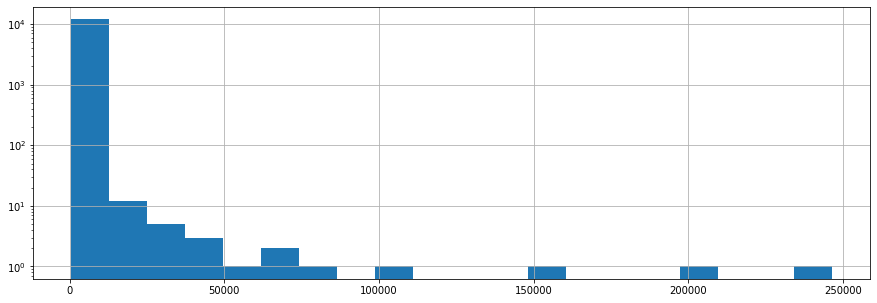

In [14]:
d = data.drop_duplicates(subset=["org_id"]).dropna(axis='index')
d.average_bill.hist(figsize=(15,5), log=True, bins=20)

In [15]:
d.average_bill.describe()

count     11998.000000
mean        999.416569
std        3777.574245
min         500.000000
25%         500.000000
50%         500.000000
75%        1000.000000
max      246500.000000
Name: average_bill, dtype: float64

Было бы замечательно не испортить его в будущем. Попробуем применить `kNN`.

In [16]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error

Но перед применением каких-либо моделей необходимо подготовить и другие столбцы. Ну а сейчас мы пройдемся по выбросам.

## Выбросы?

In [17]:
data.describe()

,user_id,org_id,rating,ts,average_bill,rating_org,food_delivery,breakfast,takeaway,summer_terrace,...,call_button,wheelchair_accessible,table_games,vinotheque,cakes_for_different_occasions,accepted_credit_cards,kalyan,teahouse,bread_from_tandoor,handmade_goods
count,7.399500e+04,7.399500e+04,73995.000000,73995.000000,45433.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,...,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000
mean,9.196627e+18,9.038261e+18,4.322779,714.540766,1075.891973,4.319332,0.757119,0.576607,0.649206,0.602554,...,0.008014,0.007406,0.017677,0.002149,0.002419,0.001027,0.000932,0.001230,0.002960,0.001216
std,5.312861e+18,5.275833e+18,1.130370,293.492213,2733.507688,0.308584,0.428827,0.494100,0.477222,0.489373,...,0.089162,0.085739,0.131775,0.046306,0.049125,0.032032,0.030523,0.035047,0.054323,0.034854
min,1.445171e+14,1.626686e+15,1.000000,0.000000,500.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.614445e+18,4.504716e+18,4.000000,505.000000,500.000000,4.180952,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.191287e+18,9.104453e+18,5.000000,699.000000,500.000000,4.368304,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.376070e+19,1.350392e+19,5.000000,958.000000,1000.000000,4.524001,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.844666e+19,1.844531e+19,5.000000,1216.000000,246500.000000,5.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
data1 = data[(data.rating > 1)] # drop low ratings

std = data1.rating.std()
mean = data1.rating.mean()
data1 = data1[(data1.rating < mean + 3 * std) & (data1.rating > mean - 3 * std)]

std = data1.average_bill.dropna().std()
mean = data1.average_bill.dropna().mean()
data1 = data1[((data1.average_bill < mean + 3 * std) & (data1.average_bill > mean - 3 * std)) | data1.average_bill.isna()]

data1.describe()

,user_id,org_id,rating,ts,average_bill,rating_org,food_delivery,breakfast,takeaway,summer_terrace,...,call_button,wheelchair_accessible,table_games,vinotheque,cakes_for_different_occasions,accepted_credit_cards,kalyan,teahouse,bread_from_tandoor,handmade_goods
count,6.722000e+04,6.722000e+04,67220.000000,67220.000000,41055.000000,67220.000000,67220.000000,67220.000000,67220.000000,67220.000000,...,67220.000000,67220.000000,67220.000000,67220.000000,67220.00000,67220.000000,67220.000000,67220.000000,67220.000000,67220.000000
mean,9.212369e+18,9.033420e+18,4.615814,711.467063,987.979540,4.340381,0.754359,0.576882,0.650952,0.602142,...,0.008108,0.007468,0.017658,0.002187,0.00238,0.000967,0.000967,0.001279,0.003109,0.001309
std,5.315456e+18,5.275956e+18,0.650496,292.783964,747.290422,0.280751,0.430470,0.494057,0.476673,0.489459,...,0.089678,0.086095,0.131708,0.046713,0.04873,0.031081,0.031081,0.035746,0.055674,0.036159
min,1.445171e+14,1.626686e+15,3.000000,0.000000,500.000000,1.103004,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.630093e+18,4.506654e+18,4.000000,502.000000,500.000000,4.202597,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.220301e+18,9.104453e+18,5.000000,696.000000,1000.000000,4.383333,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.378835e+19,1.348106e+19,5.000000,953.000000,1000.000000,4.529439,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.844666e+19,1.844474e+19,5.000000,1216.000000,9000.000000,5.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
data = data1

<AxesSubplot:>

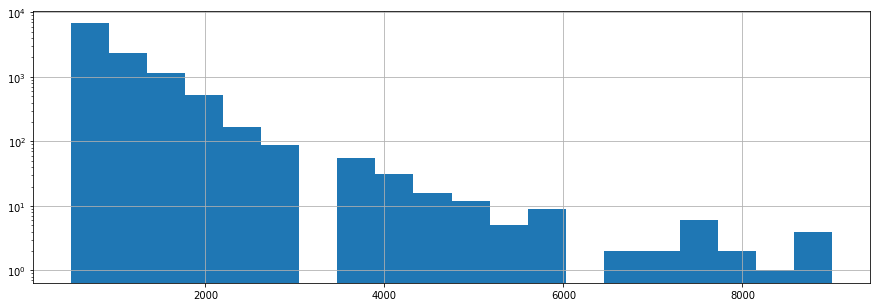

In [20]:
d = data.drop_duplicates(subset=["org_id"]).dropna(axis='index')
d.average_bill.hist(figsize=(15,5), log=True, bins=20)

Что-то на экспоненциальном.

## Подготовка столбцов, нормализация

Например, оцифруем `org_city`.

In [21]:
data["org_city"] = data["org_city"].map({"msk": 0, "spb": 1})

Затем введем новый признак `foreign_ratio` - доля рейтингов, оставленных иногородними посетителями.

In [22]:
for oid in data.org_id.unique():
    d = data[data.org_id == oid]
    u = d.user_city.value_counts()
    foreign_city = "msk" if d.org_city.values[0] == 1 else "spb"
    ratio = 0
    if foreign_city in u.index:
        ratio = u[foreign_city] / sum(u.values)
    data.loc[d.index[-1], ["foreign_ratio"]] = ratio # write to last entry

На самом деле, можно сложить все оценки пользователей по конкретному заведению в столбец `rating_mean`, вычислив его как среднее. Таким образом нам не нужно будет более хранить столбец `rating`.

In [23]:
D = [] # на сколько rating_mean отклоняется от rating_org?

for oid in data.org_id.unique():
    d = data[data.org_id == oid]
    m = d.rating.mean()
    D.append(d.rating_org.iloc[0] - m)
    data.loc[d.index[-1], ["rating_mean"]] = m

# нормализуем
data["rating_mean"] = (data["rating_mean"] - data["rating_mean"].min()) / (data["rating_mean"].max() - data["rating_mean"].min())
np.mean(D), np.std(D)

(-0.3615717498267886, 0.5696544248252717)

В то же время давайте хранить столбец "количество отзывов по заведению" - `ratings_count`

In [24]:
for oid in data.org_id.unique():
    d = data[data.org_id == oid]
    data.loc[d.index, ["ratings_count"]] = len(d)

ratings_count_divider = data["ratings_count"].max() - data["ratings_count"].min()
data["ratings_count"] = (data["ratings_count"] - data["ratings_count"].min()) / ratings_count_divider

Теперь удалим большую часть оценок пользователей, основываясь впредь на средних значениях.

In [25]:
data = data.drop_duplicates(subset=["org_id", "rating_org"], keep="last").reset_index(drop=True)
len(data)

17124

И нормализуем `rating_org`

In [26]:
data["rating_org"] = (data["rating_org"] - data["rating_org"].min()) / (data["rating_org"].max() - data["rating_org"].min())

## Подготовка машинерии

Определим столбцы, которые не будут участвовать в синтезе чего-либо.

In [27]:
ban = ["user_id", "org_id", "rating", "ts", "user_city", "rubrics"]

Заметим, что весь датасет может быть разделен по категориальному признаку `rubrics`.

In [28]:
rubrics = data.rubrics.unique()
rubrics

array(['Кафе', 'Кофейня', 'Ресторан', 'Булочная, пекарня',
       'Быстрое питание', 'Спортбар', 'Бар, паб', 'Кальян-бар',
       'Кондитерская', 'Суши-бар', 'Пиццерия', 'Столовая',
       'Бар безалкогольных напитков', 'Кофе с собой'], dtype=object)

Будем полагать, что разделение датасета на типы заведений и обучение на каждой обособленной выборке даст более хороший результат.

In [29]:
d = {}
for i in rubrics:
    d[i] = data[data.rubrics == i].copy().drop(columns=ban)

Код для обучения и тестирования.

In [30]:
def separate(train, test, column):
    train_X = train.drop(columns=[column]).to_numpy()
    train_Y = train[column].array
    test_X = test.drop(columns=[column]).to_numpy()
    test_Y = test[column].array

    return train_X, train_Y, test_X, test_Y

In [31]:
def train(train_X, train_Y, param, p=1):
    assert len(train_X) > 5, "sample is too small"
    model = KNeighborsRegressor(n_neighbors=min(len(train_X), param), weights="distance", p=p)
    model.fit(train_X, train_Y)
    return model

In [32]:
def test(test_X, test_Y, model):
    prediction = model.predict(test_X)
    error = mean_absolute_error(test_Y, prediction)
    return error

In [33]:
import sys

def brute_params(f, debug, e):
    best_error = 1e9
    best_param = None
    s = 1
    for i in range(s, e):
        if debug:
            print("\r                                       \r", end="")
            print("iteration {} of {}, best_p {}".format(i-s+1, e-s, best_param), end="")
            sys.stdout.flush()
        error = f(i)
        if error < best_error:
            best_error = error
            best_param = i
    if debug:
        print()
    return best_param, best_error

Будем использовать k-fold кросс-валидацию, если у нас будет достаточно данных для обучения, иначе - обычное разбиение 80/20.

In [34]:
def kfold_train(data, column, e=5):
    k = int(np.ceil(np.sqrt(len(data))))
    n = int(np.ceil(len(data) / k))
    prepared = []

    for i in range(0, n):
        if i * k + k >= len(data):
            break
        _test = data[i * k : len(data) if i * k + 2 * k >= len(data) else i * k + k]
        _train = data.iloc[~data.index.map(lambda i: i in _test.index)]
        prepared.append(separate(_train, _test, column))
    
    def f(k):
        errors = []
        for train_X, train_Y, test_X, test_Y in prepared:
            model = train(train_X, train_Y, k)
            error = test(test_X, test_Y, model)
            errors.append(error)
        #return sum(errors) / len(errors)
        return max(errors)

    param, _ = brute_params(f, True, e)
    return param

In [35]:
def single_pass_train(data, column, e=5):
    _train = data.sample(int(len(data) * 0.8), random_state=1337)
    _test = data.iloc[~data.index.map(lambda k: k in _train.index)]
    train_X, train_Y, test_X, test_Y = separate(_train, _test, column)

    def f(k):
        model = train(train_X, train_Y, k)
        error = test(test_X, test_Y, model)
        return error

    param, _ = brute_params(f, True, e)
    return param

In [36]:
def find_model(data, name, column, e=5):
    def final_model(data, param):
        return train(
            data.drop(columns=[column]).to_numpy(),
            data[column].array,
            param
        )

    if np.sqrt(len(data)) < 10:
        print("single-pass", name, len(data))
        return final_model(data, single_pass_train(data, column, e))
    else:
        print("kfold", name, len(data))
        return final_model(data, kfold_train(data, column, e))

## Синтезируем `average_bill`

In [37]:

ab_models = {}

for name, d2 in d.items():
    # remove `rating_org` column because test dataset doesn't have that one
    ab_models[name] = find_model(d2.drop(columns=["rating_org"]).dropna(), name, "average_bill")
 

kfold Кафе 2882
iteration 4 of 4, best_p 3             
kfold Кофейня 731
iteration 4 of 4, best_p 3             
kfold Ресторан 3700
iteration 4 of 4, best_p 3             
kfold Булочная, пекарня 255
iteration 4 of 4, best_p 3             
kfold Быстрое питание 1090
iteration 4 of 4, best_p 1             
single-pass Спортбар 38
iteration 4 of 4, best_p 1             
kfold Бар, паб 1146
iteration 4 of 4, best_p 3             
kfold Кальян-бар 222
iteration 4 of 4, best_p 2             
kfold Кондитерская 207
iteration 4 of 4, best_p 3             
kfold Суши-бар 270
iteration 4 of 4, best_p 3             
kfold Пиццерия 386
iteration 4 of 4, best_p 3             
kfold Столовая 256
iteration 4 of 4, best_p 1             
single-pass Бар безалкогольных напитков 18
iteration 4 of 4, best_p 1             
single-pass Кофе с собой 24
iteration 4 of 4, best_p 1             


Применим модели для синтеза `average_bill`.

In [38]:
for name, m in ab_models.items():
    d2 = d[name]["average_bill"]
    index = d2.isna()
    d3 = d[name]
    ab_prediction = m.predict(d3.drop(columns=["average_bill", "rating_org"])[index].to_numpy())
    d[name].loc[index, "average_bill"] = ab_prediction

In [39]:
data2 = pd.concat([d2 for _, d2 in d.items()])

In [40]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17124 entries, 0 to 17056
Data columns (total 69 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   org_city                        17124 non-null  int64  
 1   average_bill                    17124 non-null  float64
 2   rating_org                      17124 non-null  float64
 3   food_delivery                   17124 non-null  int64  
 4   breakfast                       17124 non-null  int64  
 5   takeaway                        17124 non-null  int64  
 6   summer_terrace                  17124 non-null  int64  
 7   wi_fi                           17124 non-null  int64  
 8   business_lunch                  17124 non-null  int64  
 9   payment_by_credit_card          17124 non-null  int64  
 10  coffee_to_go                    17124 non-null  int64  
 11  closed_for_quarantine           17124 non-null  int64  
 12  online_takeaway                 

<AxesSubplot:>

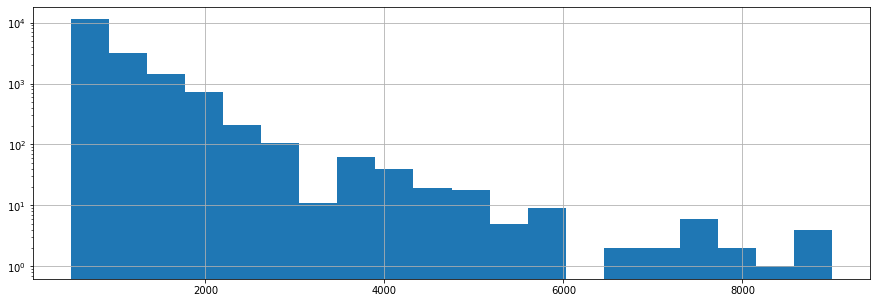

In [41]:
d2 = data2.assign(org_id=data.org_id).drop_duplicates(subset=["org_id"]).dropna(axis='index')
d2.average_bill.hist(figsize=(15,5), log=True, bins=20)

Было:

In [42]:
data.drop_duplicates(subset=["org_id"]).dropna(axis='index').average_bill.describe()

count    11225.000000
mean       882.717149
std        682.704775
min        500.000000
25%        500.000000
50%        500.000000
75%       1000.000000
max       9000.000000
Name: average_bill, dtype: float64

Стало:

In [43]:
d2.average_bill.describe()

count    17124.000000
mean       846.996935
std        620.621922
min        500.000000
25%        500.000000
50%        500.000000
75%       1000.000000
max       9000.000000
Name: average_bill, dtype: float64

Мы немного сместили центр и кв. откл, но в целом как будто бы все хорошо.

Теперь каким-нибудь способом отнормируем `average_bill`

In [44]:
for name, m in ab_models.items():
    d2 = d[name]
    d[name]["average_bill"] = (d2["average_bill"] - d2["average_bill"].min()) / (d2["average_bill"].max() - d2["average_bill"].min())

data2 = pd.concat([d2 for _, d2 in d.items()])
data2.average_bill.describe()

count    1.712400e+04
mean     4.791665e-02
std      8.745394e-02
min      0.000000e+00
25%      2.006238e-17
50%      4.263256e-17
75%      5.882353e-02
max      1.000000e+00
Name: average_bill, dtype: float64

Правда ли, что все величины отнормированы?

In [45]:
data2.min().min(), data2.max().max()

(0.0, 1.0)

## Корреляции

Уберем некоторые столбцы для наших заведений, не влияющие на их рейтинг.

In [46]:
attrs = {}

for i, j in d.items():
    corrs = j.corr(numeric_only=True).rating_org.sort_values(ascending=False) # preserve rating_org column
    attrs[i] = corrs[np.abs(corrs) > 0.12].sort_values(ascending=False, key=np.abs)[:10] # limit 10
    print(i, len(attrs[i]))

Кафе 2
Кофейня 7
Ресторан 7
Булочная, пекарня 7
Быстрое питание 7
Спортбар 10
Бар, паб 10
Кальян-бар 8
Кондитерская 3
Суши-бар 10
Пиццерия 9
Столовая 10
Бар безалкогольных напитков 10
Кофе с собой 10


In [47]:
for i, j in attrs.items():
    #break
    print(i)
    for a in j.index:
        print(a, j[a])

Кафе
rating_org 1.0
rating_mean 0.22898810103603304
Кофейня
rating_org 1.0
rating_mean 0.30000932258309065
automatic_door 0.15161378787354082
gift_certificate 0.15147343512187922
takeaway 0.1388948510280027
toilet_for_disabled 0.13779048879420916
special_menu -0.13608324395413507
Ресторан
rating_org 1.0
rating_mean 0.24566926958742905
takeaway 0.1700379220233815
average_bill 0.15398781885385504
gift_certificate 0.1295050244392722
karaoke 0.12691054258846984
craft_beer 0.1266841584604968
Булочная, пекарня
rating_org 1.0
rating_mean 0.2975635787163478
food_product_delivery 0.16646575584099246
payment_by_credit_card 0.1367140016297742
toilet_for_disabled 0.13620875746117617
ratings_count 0.12970004797714865
automatic_door 0.12537880725052458
Быстрое питание
rating_org 1.0
rating_mean 0.20949942114056389
takeaway 0.20125649697214165
breakfast 0.18372481583166791
ratings_count 0.16672221101335327
special_menu 0.16212872337805448
payment_by_credit_card 0.14114909131580977
Спортбар
rating_org

## Обучаемся предсказывать `rating_org`

Точно также обучим модели kNN.

In [48]:
models = {}

for name, d2 in d.items():
    models[name] = find_model(d2.filter(attrs[name].index), name, "rating_org", e=40)

kfold Кафе 4418
iteration 39 of 39, best_p 23          
kfold Кофейня 1157
iteration 39 of 39, best_p 16          
kfold Ресторан 4844
iteration 39 of 39, best_p 20          
kfold Булочная, пекарня 770
iteration 39 of 39, best_p 7           
kfold Быстрое питание 1759
iteration 39 of 39, best_p 8           
single-pass Спортбар 89
iteration 39 of 39, best_p 8           
kfold Бар, паб 1426
iteration 39 of 39, best_p 31          
kfold Кальян-бар 555
iteration 39 of 39, best_p 13          
kfold Кондитерская 720
iteration 39 of 39, best_p 38          
kfold Суши-бар 345
iteration 39 of 39, best_p 18          
kfold Пиццерия 591
iteration 39 of 39, best_p 3           
kfold Столовая 367
iteration 39 of 39, best_p 10          
single-pass Бар безалкогольных напитков 45
iteration 39 of 39, best_p 33          
single-pass Кофе с собой 38
iteration 39 of 39, best_p 2           


## Предсказываем рейтинг

In [49]:
final = pd.read_csv('./data/test_x.csv')
#final.rating = final.rating.apply(lambda x: max(x, 3))
set(rubrics) == set(final.rubrics.unique())

True

Высчитаем `rating_mean`.

In [50]:
for oid in final.org_id.unique():
    d2 = final[final.org_id == oid]
    m = d2.rating.mean()
    final.loc[d2.index, ["rating_mean"]] = m

final["rating_mean"] = (final["rating_mean"] - final["rating_mean"].min()) / (final["rating_mean"].max() - final["rating_mean"].min())

Оцифровываем `org_city`

In [51]:
final["org_city"] = final["org_city"].map({"msk": 0, "spb": 1})

Высчитываем столбец `foreign_ratio`

In [52]:
for oid in final.org_id.unique():
    d2 = final[final.org_id == oid]
    u = d2.user_city.value_counts()
    foreign_city = "msk" if d2.org_city.values[0] == 1 else "spb"
    ratio = 0
    if foreign_city in u.index:
        ratio = u[foreign_city] / sum(u.values)
    final.loc[d2.index, ["foreign_ratio"]] = ratio


Считаем количество отзывов.

In [53]:
for oid in final.org_id.unique():
    d2 = final[final.org_id == oid]
    final.loc[d2.index, ["ratings_count"]] = len(d2)

ratings_count_divider2 = final["ratings_count"].max() - final["ratings_count"].min()
final["ratings_count"] = (final["ratings_count"] - final["ratings_count"].min()) / ratings_count_divider2

Есть ли пропуски по `average_bill`?

In [54]:
final.average_bill.info()

<class 'pandas.core.series.Series'>
RangeIndex: 24665 entries, 0 to 24664
Series name: average_bill
Non-Null Count  Dtype  
--------------  -----  
15187 non-null  float64
dtypes: float64(1)
memory usage: 192.8 KB


Есть. Плохо. Надо их заполнить.

In [55]:
for name, m in ab_models.items():
    d2 = final[final.rubrics == name]["average_bill"]
    index = d2.isna()
    d3 = final[final.rubrics == name]
    if len(d3[index]) > 0:
        ab_prediction = m.predict(d3.drop(columns=ban+["average_bill"])[index].to_numpy())
        index2 = d2.isna()[index.values == True]
        for i in range(0, len(index2)):
            final.loc[index2.index[i], "average_bill"] = ab_prediction[i]
        #print("predicted", len(ab_prediction))

In [56]:
for name, _ in ab_models.items():
    d2 = final[final.rubrics == name]
    final.loc[final.rubrics == name, "average_bill"] = (d2["average_bill"] - d2["average_bill"].min()) / (d2["average_bill"].max() - d2["average_bill"].min())

In [57]:
final.average_bill.describe()

count    2.466500e+04
mean     2.257943e-02
std      7.954217e-02
min      0.000000e+00
25%      3.667317e-18
50%      5.685409e-04
75%      7.389163e-03
max      1.000000e+00
Name: average_bill, dtype: float64

In [58]:
final.filter(["org_id", "rating", "rating_mean"])[final.org_id == final.org_id.unique()[0]]

,org_id,rating,rating_mean
0,17145242605301041786,5.0,0.8
9930,17145242605301041786,5.0,0.8
16744,17145242605301041786,5.0,0.8
18621,17145242605301041786,1.0,0.8
24581,17145242605301041786,5.0,0.8


In [59]:
results = pd.DataFrame({
    'rating_org': [0] * len(final),
})

for name, m in models.items():
    k = final[final.rubrics == name].drop(columns=ban).filter(attrs[name].index)
    X = k.to_numpy()
    prediction = m.predict(X)
    for ind in range(0, len(k)):
        results.iloc[k.index[ind]] = prediction[ind] * 5.0

In [60]:
results

,rating_org
0,4.081671
1,4.177072
2,4.176647
3,4.113177
4,4.609458
...,...
24660,4.038669
24661,4.176647
24662,4.097274
24663,4.159310


In [61]:
results.to_csv("./solution.csv", index_label='id')

In [62]:
#results.iloc[final.drop_duplicates(subset=["org_id"]).index].to_csv("./results_unique.csv", index_label="id")

In [63]:
#data.iloc[data.drop_duplicates(subset=["org_id"]).index].to_csv("./train_unique.csv", index_label="id")